In [ ]:
!pip install tensorflow keras opencv-python numpy pandas matplotlib seaborn

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import cv2

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
import pandas as pd
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
from sklearn.model_selection import train_test_split

# Define a safe converter
def get_pixels(pixels):
    arr = np.fromstring(pixels, sep=' ', dtype='uint8')
    # Only keep valid rows (2304 = 48*48)
    if arr.size != 48*48:
        return None
    return arr.reshape(48,48)

# Apply conversion with filtering
faces = []
labels = []

for i, row in df.iterrows():
    img = get_pixels(row['pixels'])
    if img is not None:
        faces.append(img)
        labels.append(row['emotion'])

# Convert to arrays
X = np.array(faces, dtype='float32')[..., np.newaxis] / 255.0
y = to_categorical(np.array(labels))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Cleaned dataset shape:", X.shape)
print("Train:", X_train.shape, "Test:", X_test.shape)


✅ Cleaned dataset shape: (35887, 48, 48, 1)
Train: (28709, 48, 48, 1) Test: (7178, 48, 48, 1)


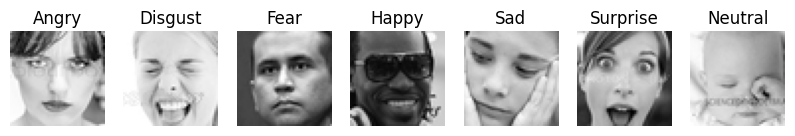

In [ ]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
plt.figure(figsize=(10,4))
for i in range(7):
    plt.subplot(1,7,i+1)
    img = X_train[y_train.argmax(axis=1)==i][0].reshape(48,48)
    plt.imshow(img, cmap='gray')
    plt.title(emotions[i])
    plt.axis('off')
plt.show()


In [ ]:
model = models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,279 (4.36 MB)

 Trainable params: 1,142,279 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=25, batch_size=64,
                    validation_split=0.1, verbose=1)

Epoch 1/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 85s 206ms/step - accuracy: 0.2429 - loss: 1.8245 - val_accuracy: 0.3553 - val_loss: 1.6057
Epoch 2/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 89s 221ms/step - accuracy: 0.3800 - loss: 1.5945 - val_accuracy: 0.4215 - val_loss: 1.4561
Epoch 3/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 136s 207ms/step - accuracy: 0.4318 - loss: 1.4773 - val_accuracy: 0.4688 - val_loss: 1.3694
Epoch 4/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 144s 212ms/step - accuracy: 0.4738 - loss: 1.3773 - val_accuracy: 0.4786 - val_loss: 1.3248
Epoch 5/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 142s 211ms/step - accuracy: 0.4964 - loss: 1.3031 - val_accuracy: 0.5026 - val_loss: 1.2622
Epoch 6/25
 43/404 ━━━━━━━━━━━━━━━━━━━━ 1:05 181ms/step - accuracy: 0.5122 - loss: 1.2583

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=emotions).plot(cmap='Blues', xticks_rotation=45)
plt.show()

In [ ]:
model.save("emotion_model.h5")

In [ ]:
import cv2, numpy as np
model = tf.keras.models.load_model("emotion_model.h5")

emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret: break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48,48))
        face = face.reshape(1,48,48,1)/255.0
        pred = emotion_labels[np.argmax(model.predict(face))]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(frame,pred,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.9,(36,255,12),2)
    cv2.imshow('Face Sentiment Recognition', frame)
    if cv2.waitKey(1) & 0xFF==ord('q'): break
cap.release(); cv2.destroyAllWindows()

In [ ]:
!pip install mediapipe



In [ ]:
%%writefile realtime_emotion_recognition_mediapipe.py
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load your trained emotion model
model = tf.keras.models.load_model("emotion_model.h5")

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize MediaPipe Face Detection
mp_face = mp.solutions.face_detection
mp_draw = mp.solutions.drawing_utils
face_detection = mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)
print("🎬 Real-time Face Sentiment Recognition started... (Press 'q' to quit)")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(rgb)
    if results.detections:
        for detection in results.detections:
            bbox = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            x, y, w, h = int(bbox.xmin*iw), int(bbox.ymin*ih), int(bbox.width*iw), int(bbox.height*ih)
            x, y = max(0, x), max(0, y)
            w, h = min(w, iw - x), min(h, ih - y)
            face_img = frame[y:y+h, x:x+w]
            if face_img.size == 0:
                continue
            face_gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
            face_gray = cv2.resize(face_gray, (48,48))
            face_gray = face_gray.reshape(1,48,48,1)/255.0
            preds = model.predict(face_gray, verbose=0)
            emotion = emotion_labels[np.argmax(preds)]
            confidence = np.max(preds)
            cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,255), 2)
            text = f"{emotion} ({confidence*100:.1f}%)"
            cv2.putText(frame, text, (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)
    cv2.imshow("MediaPipe Face Sentiment Recognition", frame)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
pip install mediapipe opencv-python tensorflow numpy

In [ ]:
!python realtime_emotion_recognition_mediapipe.py